## **파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측**

**위스콘신 유방암 데이터 세트는 종양의 크기, 모양 등의 다양한 속성값을 기반으로 악성 종양(malignant)과 양성 종양(benign)인지를 분류한 데이터 세트이다.**

**종양은 양성 종양과 악성 종양으로 구분할 수 있으며, 양성 종양이 비교적 성장 속도가 느리고 전이되지 않는 것에 반해, 악성 종양은 주위 조직에 침입하면서 빠르게 성장하고 신체 각 부위에 확산되거나 전이되어 생명을 위협한다.**

In [4]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [5]:
# 유방암 데이터 불러오기
dataset = load_breast_cancer()

X_features = dataset.data
y_label = dataset.target

In [6]:
# numpy -> DataFrame
# target -> malignant:0 benign:1
cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [7]:
# 악성이 212, 양성이 357
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [8]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                   test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [9]:
# 파이썬 래퍼와 사이킷런은 차이가 여러 있지만, 먼저 눈에 띄는 차이는 학습용과 테스트용 데이터 세트를 위해 별도의 객체인 DMatrix를 생성
# Dmatrix는 주로 넘파이 입력 파라미터를 받아서 만들어지는 XGBoost만의 전용 데이터 세트이다. 
# Dmatrix의 주요 입력 파라미터는 data와 label이다.
# data는 피처 데이터 세트이며, label은 분류의 경우에는 레이블 데이터 세트, 회귀의 경우 숫자형인 종속값 데이터 세트이다.
# Dmatrix는 넘파이 외에 libsvm txt 포맷 파일, xgboost 이진 버퍼 파일을 파라미터로 입력받아 변환할 수 있다. 
# pandas의 DataFrame으로 데이터 인터페이스를 하기 위해서는 DataFrame.values를 이용해 넘파이로 일차 변환한 뒤에 이를 이용해 
# Dmatrix 변환을 적용
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [10]:
# 파이썬 래퍼 XGBoost 모듈인 xgboost를 이용해 학습을 수행하기 전에 먼저 XGBoost의 하이퍼 파라미터 설정

params = {
    'max_depth':3, # 트리의 최대 깊이
    'eta':0.1, # 학습률
    'objective':'binary:logistic', # 이진 로지스틱
    'eval_metric':'logloss', # 평가 성능 지표
    'early_stoppings':100 # 최소 반복 횟수
}
num_rounds = 400

In [11]:
# 지정된 하이퍼 파라미터로 XGBoost 모델을 학습
# 파이썬 래퍼 XGBoost는 하이퍼 파라미터를 xgboost 모듈의 train() 함수에 파라미터로 전달한다.
# 사이킷런의 경우는 Estimator의 생성자를 하이퍼 파라미터로 전달하는 데 반해 차이가 있다.
# early_stopping_rounds 파라미터를 설정해 조기 중단을 수행하기 위해서는 반드시 eval_set과 eval_metric이 함께 설정돼야 한다.
# Xgboost는 반복마다 eval_set으로 지정된 데이터 세트에서 eval_metric의 지정된 평가 지표로 예측 오류를 측정
# evals 파라미터에 학습 데이터 세트와 eval 데이터 세트를 명기해주면 평가를 eval 데이터 세트에 수행하면서 조기 중단을 적용

# xgboost 모듈의 train() 함수를 호출하면 학습을 수행
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기한다.
wlist = [(dtrain,'train'),(dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[0]	train-logloss:0.609688	eval-logloss:0.61352
[1]	train-logloss:0.540803	eval-logloss:0.547842
[2]	train-logloss:0.483753	eval-logloss:0.494247
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354145	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292593	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207937	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logloss:0.133985	eval-logloss:0.181818
[18]	train-logloss:0.125599	eval-logloss:0.174729
[19]	train-logloss:0.117286	eval-logloss:0.167657
[20]	train-logl

[164]	train-logloss:0.0072	eval-logloss:0.087777
[165]	train-logloss:0.00718	eval-logloss:0.087517
[166]	train-logloss:0.007161	eval-logloss:0.087542
[167]	train-logloss:0.007142	eval-logloss:0.087642
[168]	train-logloss:0.007122	eval-logloss:0.08739
[169]	train-logloss:0.007103	eval-logloss:0.087377
[170]	train-logloss:0.007084	eval-logloss:0.087298
[171]	train-logloss:0.007065	eval-logloss:0.087368
[172]	train-logloss:0.007047	eval-logloss:0.087395
[173]	train-logloss:0.007028	eval-logloss:0.087385
[174]	train-logloss:0.007009	eval-logloss:0.087132
[175]	train-logloss:0.006991	eval-logloss:0.087159
[176]	train-logloss:0.006973	eval-logloss:0.086955
[177]	train-logloss:0.006955	eval-logloss:0.087053
[178]	train-logloss:0.006937	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.086973
[180]	train-logloss:0.006901	eval-logloss:0.087038
[181]	train-logloss:0.006884	eval-logloss:0.086799
[182]	train-logloss:0.006866	eval-logloss:0.086826
[183]	train-logloss:0.006849	eval-log

[326]	train-logloss:0.005354	eval-logloss:0.08578
[327]	train-logloss:0.005348	eval-logloss:0.085857
[328]	train-logloss:0.005342	eval-logloss:0.085939
[329]	train-logloss:0.005336	eval-logloss:0.085825
[330]	train-logloss:0.00533	eval-logloss:0.085869
[331]	train-logloss:0.005324	eval-logloss:0.085893
[332]	train-logloss:0.005318	eval-logloss:0.085922
[333]	train-logloss:0.005312	eval-logloss:0.085842
[334]	train-logloss:0.005306	eval-logloss:0.085735
[335]	train-logloss:0.0053	eval-logloss:0.085816
[336]	train-logloss:0.005294	eval-logloss:0.085892
[337]	train-logloss:0.005288	eval-logloss:0.085936
[338]	train-logloss:0.005283	eval-logloss:0.08583
[339]	train-logloss:0.005277	eval-logloss:0.085909
[340]	train-logloss:0.005271	eval-logloss:0.085831
[341]	train-logloss:0.005265	eval-logloss:0.085727
[342]	train-logloss:0.00526	eval-logloss:0.085678
[343]	train-logloss:0.005254	eval-logloss:0.085721
[344]	train-logloss:0.005249	eval-logloss:0.085796
[345]	train-logloss:0.005243	eval-log

**train()으로 학습을 수행하면 반복 시 train-error와 eval-logloss가 지속적으로 감소한다.**

**xgboost를 이용해 모델의 학습이 완료됐으면 이를 이용해 테스트 데이터 세트에 예측을 수행해 보는데, 파이썬 래퍼 XGBoost는 train() 함수를 호출해 학습이 완료된 모델 객체를 반환하게 되는데, 이 모델 객체는 예측을 위해 predict()메서드를 이용한다.**

**한 가지 유의할 점은 사이킷런의 predict()메서드는 예측 결과 클래스 값(즉, 0,1)을 반환하는 데 반해 xgboost의 predict()는 예측 결괏값이 아닌 예측 결과를 추정할 수 있는 확률 값을 반환한다는 것이다.**

In [12]:
# 본 예제는 암이 악성인지, 양성인지를 판단하는 이진 분류이므로 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측 값을
# 결정하는 로직을 추가하면 된다.

pred_probs = xgb_model.predict(dtest)
print('predict () 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict () 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [21]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도:{:.4f}, 정밀도:{:.4f}, 재현율:{:.4f}'.format(accuracy,precision,recall))

In [24]:
get_clf_eval(y_test,preds)

오차 행렬
[[35  2]
 [ 1 76]]
정확도:0.9737, 정밀도:0.9744, 재현율:0.9870


**XGBoost의 plot_importance() API는 피처의 중요도를 막대그래프 형식으로 나타낸다.**

> **기본 평가 지표로 F1스코어를 기반으로 각 피처의 중요도를 나타낸다.**

> **사이킷런은 Estimator 객체의 feature_importances_ 속성을 이용해 직접 시각화 코드를 작성해야 하지만, xgboost 패키지는 plot_importance()를 이용해 바로 피처 중요도를 시각화**

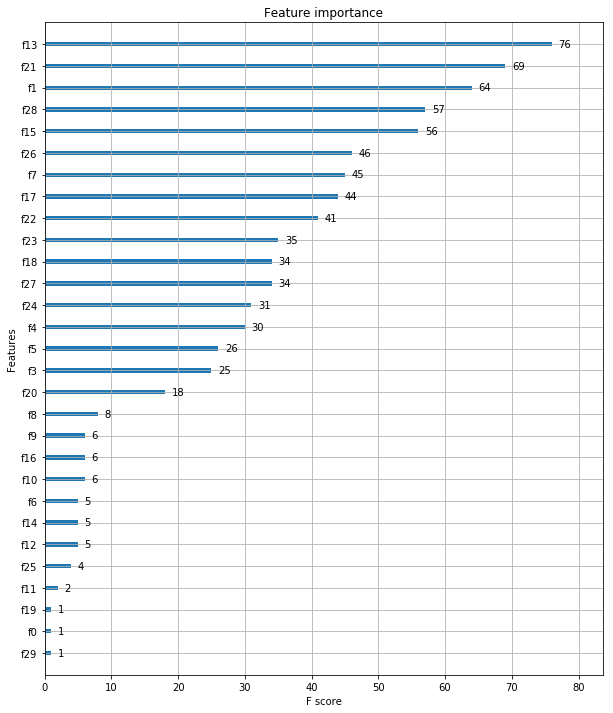

In [26]:
# 변수 중요도
# plot_importance() 호출 시 파라미터로 앞에서 학습이 완료된 모델 객체 및 맷플롯립의 ax 객체를 입력하기만 하면 된다.
# 유의할 점은 xgboost 넘파이 기반의 피처 데이터로 학습 시에는 피처명을 제대로 알 수 가 없으므로, 
# f0,f1와 같이 피처 순서별로 f자 뒤에 순서를 붙여서 X축에 피처로 나열한다(즉, f0은 첫 번째 피처, f1는 두 번째 피처를 의미)

from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax)

**파이썬 래퍼 XGBoost는 사이킷런의 GridSearchCV와 유사하게 데이터 세트에 대한 교차 검증 수행 후 최적 파라미터를 구할 수 있는 방법을 CV() API로 제공한다.**

> **params (dict): 부스트 파라미터**

> **dtrain (DMatrix): 학습 데이터**

> **num_boost_round (int): 부스팅 반복 횟수**

> **nfold (int): CV 폴드 개수**

> **Stratified (bool): CV 수행 시 층화 표본 추출(stratified sampling) 수행 여부**

> **metrics (string or list of strings): CV 수행 시 모니터링할 성능 평가 지표**

> **early_stopping_rounds (int): 조기 중간을 활성화 시킴. 반복 횟수 지정**

**xgb.cv의 반환값은 DataFrame 형태이다.**

### **사이킷런 XGBoost 래퍼**

In [43]:
#  모델의 하이퍼 파라미터는 앞의 파이썬 래퍼 XGBoost와 동일하게 n_estimaors(num_rounds 대응)는 400,
# learning_rate(eta 대응)는 0.1, max_depth=3으로 설정한다.

# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier import
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train,y_train)
w_preds = xgb_wrapper.predict(X_test)

In [44]:
# get_clf_eval를 이용해 사이킷런 래퍼 XGBoost로 만들어진 모델의 예측 성능 평가
get_clf_eval(y_test,w_preds)

오차 행렬
[[35  2]
 [ 1 76]]
정확도:0.9737, 정밀도:0.9744, 재현율:0.9870


**사이킷런 래퍼 XGBoost에서도 조기 중단을 수행할 수 있다. 조기 중단 관련한 파라미터를 fit()에 입력하면 된다.**

> **조기 중단 관련 파라미터는 평가 지표가 향상될 수 있는 반복 횟수를 정의하면 early_stopping_rounds, 조기 중단을 위한 평가 지표인 eval_metric, 그리고 성능 평가를 수행할 데이터 세트인 eval_set이다. 성능 평가를 수행할 데이터 세트는 학습 데이터가 아니라 별도의 데이터 세트여야 한다.**

In [9]:
# 테스트 데이터 세트는 학습 시에는 완전히 알려지지 않은 데이터 세트를 사용해야한다.
# 평가에 테스트 데이터 세트를 사용하면 학습 시에 미리 참고가 되어 과적합할 수 있기 때문이다.
# 이 예제에서는 데이터 세트의 크기가 작아 테스트 데이터를 평가용으로 사용했으니, 이 부분을 주시해야한다.

from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test,y_test)]
xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='logloss',
               eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

[230]	validation_0-logloss:0.086002
[231]	validation_0-logloss:0.085922
[232]	validation_0-logloss:0.086102
[233]	validation_0-logloss:0.086115
[234]	validation_0-logloss:0.086169
[235]	validation_0-logloss:0.086263
[236]	validation_0-logloss:0.086292
[237]	validation_0-logloss:0.086217
[238]	validation_0-logloss:0.086395
[239]	validation_0-logloss:0.086342
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.086195
[242]	validation_0-logloss:0.086248
[243]	validation_0-logloss:0.086263
[244]	validation_0-logloss:0.086293
[245]	validation_0-logloss:0.086222
[246]	validation_0-logloss:0.086398
[247]	validation_0-logloss:0.086347
[248]	validation_0-logloss:0.086276
[249]	validation_0-logloss:0.086448
[250]	validation_0-logloss:0.086294
[251]	validation_0-logloss:0.086312
[252]	validation_0-logloss:0.086364
[253]	validation_0-logloss:0.086394
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.086441
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08

**n_estimators를 400으로 설정해도 400번 반복을 수행하지 않고 311번 반복한 후 학습을 완료했음을 알 수 있다. 311번 반복 시 logloss가 0.085948인데, 211번에서 311번까지 100번의 반복 동안 성능 평가 지수가 향상되지 않았기 때문에 더 이상 반복하지 않고 멈춘 것이다.**

In [13]:
# 조기 중단으로 확습된 XGBClassifier의 예측성능을 평가
# 조기 중단이 적용되지 않은 결과 보다 약간 저조한 성능을 나타냈지만, 큰 차이는 아니다.

get_clf_eval(y_test,ws100_preds)

오차 행렬
[[34  3]
 [ 1 76]]
정확도:0.9649, 정밀도:0.9620, 재현율:0.9870


In [17]:
# 하지만 조기 중단값을 너무 급격하게 줄이면 예측 성능이 저하될 우려가 있다.
# 만일 조기 중단을 10으로 하면 아직 성능이 향상될 여지가 있음에도 불구하고 10번 반복하는 동안 성능 평가 지표가 향상되지 않으면
# 반복이 멈춰 버려서 충분한 학습이 되지 않아 예측 성능이 나빠질 수 있다.

# early_stopping_rounds를 10으로 설정하고 재 학습
xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=10,
               eval_metric='logloss',eval_set=evals,verbose=True)

ws10_pred = xgb_wrapper.predict(X_test)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


In [16]:
get_clf_eval(y_test,ws10_pred)

오차 행렬
[[34  3]
 [ 2 75]]
정확도:0.9561, 정밀도:0.9615, 재현율:0.9740


**62번 반복까지만 수행된 후 학습이 종료됐는데, 62번 반복의 logloss가 0.90311, 52번 반복의 logloss가 0.089577로서 10번의 반복 동안 성능 평가 지수가 향상되지 못해서 더 이상의 반복을 수행하지 않고 학습이 종료됐다. 이렇게 학습된 모델로 예측한 결과 정확도는 약 0.9561로 early_stopping_rounds=100일 떄의 약 0.9649보다 낮다.**

**피처의 중요도를 시각화하는 모듈인 plot_importance() API에 사이킷런 래퍼 클래스를 입력해도 피처의 중요도를 시각화할 수 있다.**

In [18]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

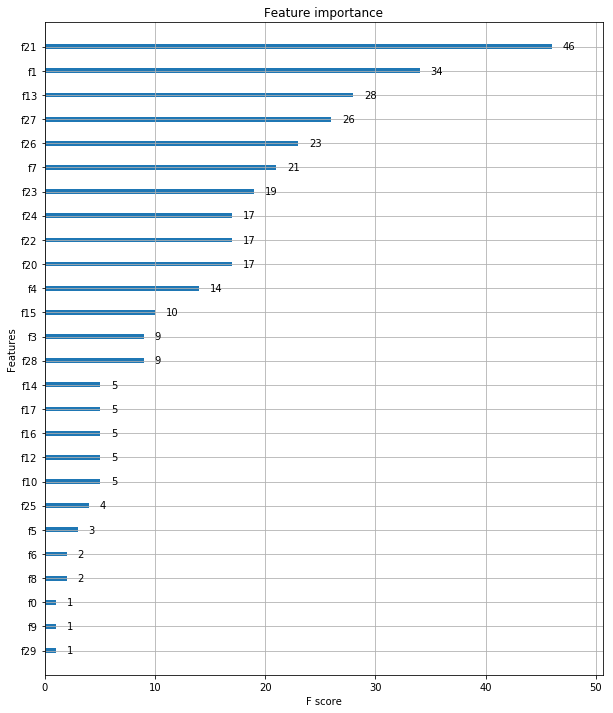

In [19]:
fig, ax = plt.subplots(figsize=(10,12))

# 사이킷런 Wrapper 클래스를 입력해도 무방.
plot_importance(xgb_wrapper,ax=ax)

### **LightGBM 적용 - 위스콘신 유방암 예측**

**앞서 LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier를 임포트해 사용. LightGBM도 XGBoost와 동일하기 조기 중단(early stopping)이 가능하다.(fit()에 조기 중단 관련 파라미터를 설정해주면 된다.)**

In [2]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [3]:
# 유방암 데이터 불러오기
dataset = load_breast_cancer()
data = dataset.data # feature
target = dataset.target # target

In [14]:
target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [15]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=156)

In [17]:
# 앞서 XGBoost와 동일하게 n_estimator는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators=400)

In [18]:
# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_test,y_test)]
lgbm_wrapper.fit(X_train,y_train, early_stopping_rounds=100, eval_metric='logloss',eval_set=evals,verbose=True)
preds = lgbm_wrapper.predict(X_test)

[1]	valid_0's binary_logloss: 0.565079	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.507451	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865	valid_0's bi

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=400, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [22]:
get_clf_eval(y_test,preds)

오차 행렬
[[33  4]
 [ 2 75]]
정확도:0.9474, 정밀도:0.9494, 재현율:0.9740


**정확도가 약 94.74%이다. 앞 예제의 XGBoost인 경우의 약 96.49%보다는 작습니다만, 워낙 학습 데이터 세트와 테스트 데이터 세트 크기가 작아서 알고리즘 간 성능 비교는 큰 의미가 없다.**

In [23]:
# xgboost와 동일하게 피처 중요도를 시각화할 수 있는 내장 API를 제공한다.
# 이름도 동일하게 plot_importance()이다.
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

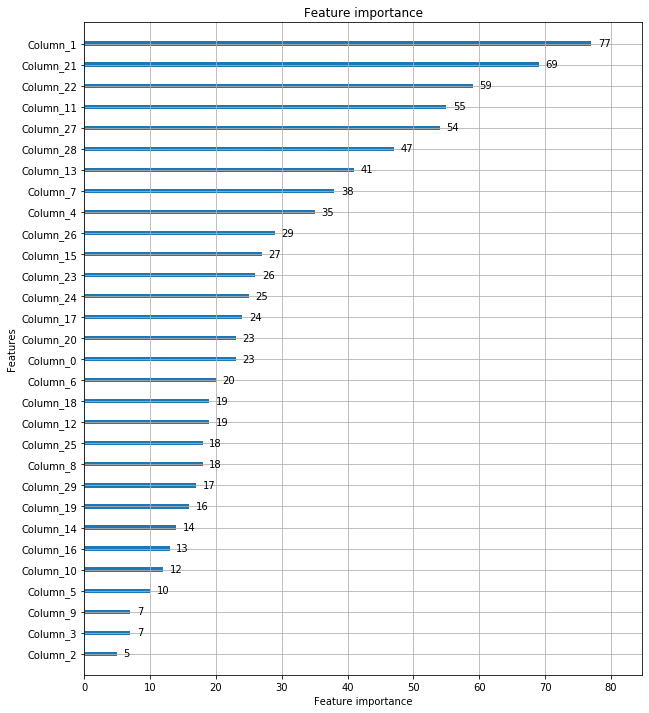

In [24]:
# lightgbm에 내장된 plot_importance() 역시 넘파이로 피처 데이터를 학습할 경우 피처명을 알 수 없기에 column_뒤에
# 피처 순서대로 숫자를 붙여서 X축에 나열한다.(즉, Column_0은 첫 번째 피처, Column_1은 두 번째 피처)
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper,ax=ax)